In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SGLBO

from skopt import gp_minimize, expected_minimum


#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF

from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, RBF

## PQC

C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


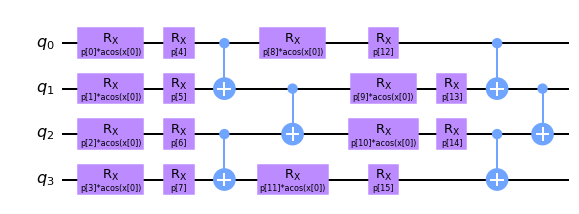

In [2]:
num_shots = 50

executor = Executor("statevector_simulator")
#executor.set_shots(num_shots)

nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw("mpl")

## Observable

In [3]:
op = SummedPaulis(nqubits)
print(op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


In [4]:
def sigmoid(x, a, b, c):
    return 1 / (1 + np.exp(-a * (x - b) / c))

In [5]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13)
param_ini =  np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.random.rand(op.num_parameters)

x_train = np.arange(-1, 1.1, 0.1)
y_train = sigmoid(x_train, 5, 0, 1)



In [6]:
x0 = [[1e-6], [5e-6], [1e-5], [5e-5]]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 0.2)], "log_file": "sglbo_sigmoid_noise_new.log",
                     "bo_n_calls": 60, "bo_x0_points": x0, "maxiter": 300}

qnn_noisy = QNNRegressor(
    pqc,
    op,
    executor,
    SquaredLoss(),
    SGLBO(optimizer_options),
    param_ini,
    param_op_ini=param_op_ini,
)

qnn_noisefree = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    SGLBO(optimizer_options),
    param_ini,
    param_op_ini=param_op_ini,
)

In [7]:
def evaluate_loss(theta, qnn_regressor: QNNRegressor, X, y):
    param = theta[: qnn_regressor._qnn.num_parameters]
    param_op = theta[qnn_regressor._qnn.num_parameters :]

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.loss_args_tuple, X, param, param_op)

    loss_value = qnn_regressor.loss.value(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value


def evaluate_loss_variance(theta, qnn_regressor: QNNRegressor, X, y):
    param = theta[: qnn_regressor._qnn.num_parameters]
    param_op = theta[qnn_regressor._qnn.num_parameters :]

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.variance_args_tuple, X, param, param_op)

    loss_value = qnn_regressor.loss.variance(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value


In [8]:
param = np.array([ 0.90188812,  0.24107649,  0.77594797,  1.42321801,  1.1142016 ,  0.44067169,
  0.52859497,  0.92242668,  0.01521759,  0.69437114,  0.13113242,  0.76001705,
 -0.16016357,  0.81846978,  0.4212208 ,  0.82229221,  0.79631544,  0.32070702,
  0.10292222,  0.42838383,  0.97817512])


grad = np.array([ 2.38344023, -3.14310031,  0.51410924,  1.99572056,  0.96659542, -1.49326947,
  0.33410333,  1.15420496,  0.28851028,  0.92035961, -1.49312591,  1.97126941,
  0.13215843,  0.55944491, -0.76135106,  1.18595071, -4.06515594,  2.88410852,
  0.43698936,  0.01215489,  0.93930853])



evaluate_loss_variance(param, qnn_noisefree, x_train, y_train)

2.390263245750887

In [9]:
def loss_noisy(x):
    return evaluate_loss(x,qnn_noisy,x_train,y_train)

def loss_noisefree(x):
    return evaluate_loss(x,qnn_noisefree,x_train,y_train)


In [10]:
bo_bounds = [(0.0, 0.2)]
bo_n_calls = 60
bo_aqc_func = "EI"
bo_aqc_optimizer = "lbfgs"
bo_x0_points = x0
bo_noise = "gaussian"  #  evaluate_loss_variance(param, qnn_noisefree, x_train, y_train)/num_shots

In [11]:
  # cost function to optimize the step size in one dimension
x_list = []
y_list = []


def step_size_cost(x):
    fval = loss_noisy(param-x*grad)
    x_list.append(x)
    y_list.append(fval)
    # print("BOP ", "fval: ", fval, " x: ", x)
    return fval

def step_size_cost_ref(x):
    fval = loss_noisefree(param-x*grad)
    x_list.append(x)
    y_list.append(fval)
    # print("BOP ", "fval: ", fval, " x: ", x)
    return fval


def step_size_cost_print(x):
    fval = loss_noisy(param-x*grad)
    x_list.append(x)
    y_list.append(fval)
    print("BOP ", "fval: ", fval, " x: ", x)
    return fval

# bayesian optimization to estimate the step size in one dimension
res = gp_minimize(    step_size_cost_print, bo_bounds, n_calls=bo_n_calls, acq_func=bo_aqc_func,
                        acq_optimizer=bo_aqc_optimizer, x0=bo_x0_points, n_jobs=-1, random_state=10, noise=bo_noise, n_initial_points=0)
x_val, fun = expected_minimum(res)
x_val = res.x
fun = res.fun

BOP  fval:  0.664038672416117  x:  [1e-06]
BOP  fval:  0.6638053656653555  x:  [5e-06]
BOP  fval:  0.6635138519564381  x:  [1e-05]
BOP  fval:  0.66118653159136  x:  [5e-05]
BOP  fval:  5.746141479147324  x:  [0.05975223037712566]
BOP  fval:  31.490729602409427  x:  [0.2]
BOP  fval:  0.3629493950444598  x:  [0.013592264241472408]
BOP  fval:  0.34514497477468303  x:  [0.010581247786147751]
BOP  fval:  0.34476991159036335  x:  [0.010906474617282683]
BOP  fval:  0.3742052730042197  x:  [0.01431010391488636]
BOP  fval:  0.34525671089825405  x:  [0.010529258468539613]
BOP  fval:  0.3451100674675658  x:  [0.010599012497997167]
BOP  fval:  0.34499891688957274  x:  [0.010662513615704416]
BOP  fval:  0.3449422141768425  x:  [0.01070078369332535]
BOP  fval:  0.34492167763529336  x:  [0.010716107771887176]
BOP  fval:  0.3449350356975039  x:  [0.010706035962716473]
BOP  fval:  0.34484350312927553  x:  [0.010786248624596099]
BOP  fval:  0.34491108092821277  x:  [0.010724400704763047]
BOP  fval:  0.3

In [12]:
print("Final step size:",res.x)
print("Final value",res.fun)

Final step size: [0.010997867947615817]
Final value 0.3447649981209768


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

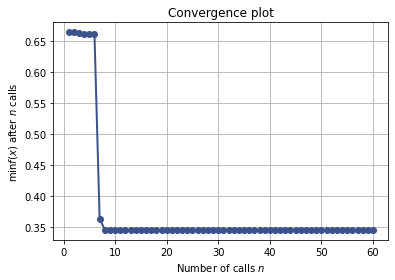

In [13]:
from skopt.plots import plot_convergence

plot_convergence(res)

<AxesSubplot:title={'center':'x* = 0.0110, f(x*) = 0.3448'}, xlabel='x', ylabel='f(x)'>

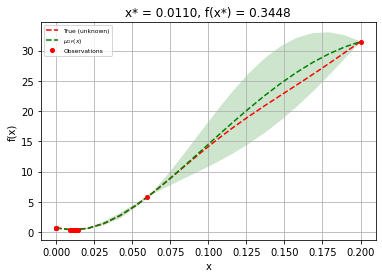

In [14]:
from skopt.plots import plot_gaussian_process

plot_gaussian_process(res, n_calls=len(res.models)-1, objective=step_size_cost_ref, n_points=20)

C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\skopt\learning\gaussian_process\gpr.py:338: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


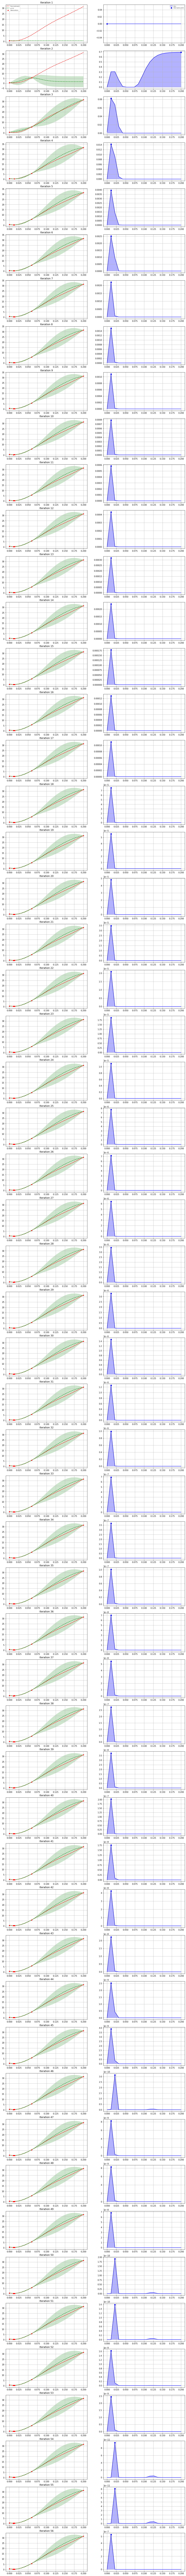

In [15]:
#plt.rcParams["figure.figsize"] = (16, 160)

plt.figure(figsize=(16, 240))


for n_iter in range(len(res.models)-1):
    # Plot true function.
    plt.subplot(len(res.models), 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,n_points=20,
                               objective=step_size_cost_ref,
                               noise_level=0.1,
                               show_legend=show_legend, show_title=False,
                               show_next_point=True, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Iteration %d" % (n_iter + 1))
    # Plot EI(x)
    plt.subplot(len(res.models), 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,n_points=20,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

In [16]:
res.x_iters

[[1e-06],
 [5e-06],
 [1e-05],
 [5e-05],
 [0.05975223037712566],
 [0.2],
 [0.013592264241472408],
 [0.010581247786147751],
 [0.010906474617282683],
 [0.01431010391488636],
 [0.010529258468539613],
 [0.010599012497997167],
 [0.010662513615704416],
 [0.01070078369332535],
 [0.010716107771887176],
 [0.010706035962716473],
 [0.010786248624596099],
 [0.010724400704763047],
 [0.010850420403826555],
 [0.012148034760870428],
 [0.010493967293553778],
 [0.010507160423412912],
 [0.012395366009244686],
 [0.010273020872705582],
 [0.010355165938034297],
 [0.012221797142806759],
 [0.010256801839624855],
 [0.010251227645274327],
 [0.012242565409516829],
 [0.010329004619422991],
 [0.010233574112041403],
 [0.012262000770736775],
 [0.010242945615631797],
 [0.010164322648779693],
 [0.01234121146874183],
 [0.010695977274458993],
 [0.011461636507878284],
 [0.009904381881488037],
 [0.012046887525076329],
 [0.012041457947078942],
 [0.010997867947615817],
 [0.010472098781313543],
 [0.011144299161947216],
 [0.01

In [17]:
def fun_min(x):
    fval = res.models[-1].predict(res.space.transform(np.array([x])))[0]
    print(x, fval)
    return fval

from scipy.optimize import minimize

res2 = minimize(fun_min, x0=res.x[0], method='Nelder-Mead', tol=1e-6)

print(res2.x)
print(res.x)

[0.01099787] 0.34468470530599804
[0.01154776] 0.3454608643569801
[0.01044797] 0.34556495219112815
[0.01127281] 0.3448659480298616
[0.01072292] 0.34491759343382367
[0.01113534] 0.3447235864375813
[0.01086039] 0.34474935871378776
[0.0110666] 0.3446912072705378
[0.01092913] 0.34470408708773004
[0.01103224] 0.3446847212170394
[0.0109635] 0.3446911603342896
[0.01101505] 0.34468390444243846
[0.01103224] 0.3446847212186439
[0.01100646] 0.3446841026640616
[0.01102364] 0.34468411063064197
[0.01101076] 0.34468395300149157
[0.01101935] 0.3446839569881055
[0.0110129] 0.3446839160837246
[0.0110172] 0.34468391807734666
[0.01101398] 0.3446839071029125
[0.01101613] 0.34468390810167193
[0.01101452] 0.3446839049833925
[0.01101505]
[0.010997867947615817]


[0.] 0.6637945841401073
[0.0020202] 0.5606026655694505
[0.0040404] 0.47606625741478736
[0.00606061] 0.4115632038182311
[0.00808081] 0.3682609170992489
[0.01010101] 0.3469736969956877
[0.01212121] 0.34803031978836707
[0.01414141] 0.37130707859728207
[0.01616162] 0.4165027042956875
[0.01818182] 0.4832622087378099
[0.02020202] 0.5711868879318789
[0.02222222] 0.6798377874551647
[0.02424242] 0.8087391107463271
[0.02626263] 0.9573815408323321
[0.02828283] 1.125225481878235
[0.03030303] 1.3117042268152455
[0.03232323] 1.516227057237271
[0.03434343] 1.7381822816600967
[0.03636364] 1.9769402181322644
[0.03838384] 2.2318561271533577
[0.04040404] 2.502273100770709
[0.04242424] 2.7875249136316174
[0.04444444] 3.086938841833329
[0.04646465] 3.3998384551734313
[0.04848485] 3.72554638860704
[0.05050505] 4.063387098448047
[0.05252525] 4.41268960902402
[0.05454545] 4.77279025536558
[0.05656566] 5.143035427498572
[0.05858586] 5.522784322015467
[0.06060606] 5.911411706050702
[0.06262626] 6.30831052651438

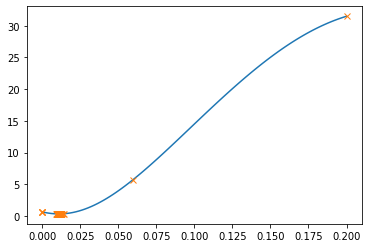

In [18]:
xx = np.linspace(0, 0.2, 100).reshape(-1, 1)
plt.figure()


plt.plot(xx, [fun_min(x) for x in xx])
plt.plot(res.x_iters, res.func_vals, 'x')